# Building our own K-Means Algorithm Implementation

The K-Means clustering algorithm is a popular clustering algorithm that separates our data points into *k* clusters of affinity. It's not a predictive algorithm, meaning, it's not generally used to predict behvarior of new data. It's more often used to find similarities between clusters of existing data for descriptive purposes.  I had a chance to ues k-means in my university academic work on a set of business customer characteristic data.  We were looking for segments of customers to develop individual marketing plans to.  We knew we wanted to target between 4 and 6 different clusters, and the algorithm was a useful supplement to our theoretical justification of our marketing splits.

You'll come out of this notebook having handwritten the *k*-means clustering algorithm.  You'll also see how we can deal with the problem of k-means having a non-convex loss function.  

For our first step, I'm loading the basic packages used for data manipulation and loading.  

In [2]:
# import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from IPython.display import Image
from IPython.core.display import HTML

# importing a printing utility
sys.path.append('../utils')            
import dim_reduction_plotting as plotting_util

In the first cell, we load up one of the datasets

In [3]:
# path to data
basepath = '../datasets/'
dataname = '5cluster_2d_data.csv'
X = np.asarray(pd.read_csv(basepath + dataname,header = None))

First, we'll visualize the data.  

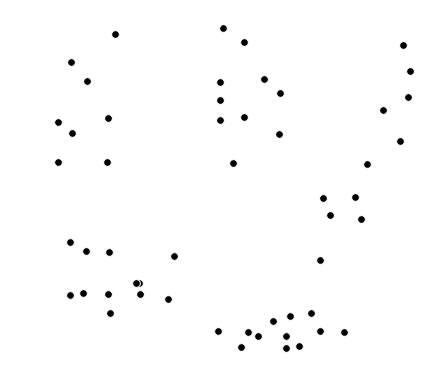

In [4]:
%matplotlib inline

# plot dataset
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, aspect = 'equal')
ax.scatter(X[:,0],X[:,1],c = 'k',s = 60,edgecolor = 'w')
ax.axis('off');

We can see that there are a couple distinct clusters in here -- Perfect input data for our k-means algorithm.  Our data is 2 dimensional, which lets us spot check to see that the optimal set of clusters should be 5.  Of course, most data you'll work with won't have this sort of obvious choice of clusters. Later in this notebook I'll cover how we can think about selecting the right number of clusters. For now, we'll write our algorithm agnostic to number of clusters.

### Implementation

Our algorithm will maintain the same nomenclature as scikit learn's k-means functionality.  It will take:

```X``` - your dataset 

```num_clusters``` - a number of desired clusters

and should return two things:

```centroids``` - the returned centroids.  These are center points of each cluster.

```assignments``` - the set of labels assigning each point to a cluster.

### The Algorithm

The k-means algorithm can be broken down into 2 individually optimizable functions by virtue of Lloyd's algorithm.  The process goes as follows:

1. Place *k* points somewhere randomly in the input domain to serve as initial centroids
2. Assign each *n* points to its nearest centroid.  We are minimizing the distance between each point to their centroid.
3. Move each centroid to the center of its assigned points.
4. Repeat steps 2 and 3 

Easy! 

We'll first code up our loss function.  We'll be constantly minimizing the distance between points and centroids, so we'll be creating a function to wrap it up.  For each point and set of centroids passed to it it, it'll return the distance from that point and each of those centroids.

In [5]:
## Distance function measures the distance from each point to to each centroid
def distance(x, centroids):
    return [np.sum((x - c)**2) for c in centroids]

Below I code up the k-means algorithm with a default 100 iterations to find the minimum point.  See further below for a run through of the code.

In [6]:
## Primary K-Means Function takes the number of iterations to find the
## allocation of points that gives the lowest error 
def my_kmeans(X,num_clusters, max_iters=100):
    # Assigns *k* random points to be initial centroids
    centroids = X[np.random.choice(range(len(X)), num_clusters),:]
    # build an array of assignments
    assignments = range(len(X))
    # run max_iters amount of iterations to find the loss minimum
    for i in range(max_iters):
        # assign each point to its nearest centroid
        assignments = [np.argmin(distance(x, centroids)) for x in X]
        # Move each centroid to the center of all the points assigned to it.
        for j in np.unique(assignments):
            temp_X = X[assignments==j]
            centroids[j] = [temp_X[:,0].mean(), temp_X[:,1].mean()]  
    assignments = np.asarray(assignments)
    return centroids,assignments

In [15]:
# run the k-means algorithm below
centroids,assignments = my_kmeans(X = X,num_clusters = 5)

With our centroids and assignment labels in hand, lets plot the original dataset colored by cluster membership as well as the cluster centroids (as stars of the same color as its cluster).

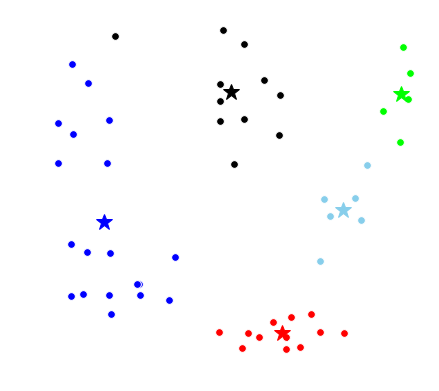

In [16]:
# print out dataset again, only with each cluster colored individually, 
# and plot centroids
plotting_util.cluster_plot_2d(X,centroids,assignments)

### Comments

Uh oh! Looks like our model did not produce an optimal result.

Plenty of runs do not end with the optimal solution.  Plenty of runs end with a very obvious case of "this could be divied up better".  To solve this, I'll be running a 'super loop' on the data, choosing the run that has the lowest total loss on each point

### Why does this happen?

The K-means loss function is not naturally convex. The process of assigning *N* points to *K* clusters can fall into an exponential number of locally optimal assignments of points. Consider the loss function graphed to the right below.  In the process of assigning and re-assigning points to minimize loss, the k-means algorithm will frequently fall down the wrong 'path' for finding the global loss minimum.

In [16]:
Image(url= "https://image.slidesharecdn.com/mlconf2015-sf-anandkumar-1511140021\
55-lva1-app6892/95/animashree-anandkumar-electrical-engineering-and-cs-dept-uc-\
irvine-at-mlconf-sf-111315-10-638.jpg?cb=1447460604", width=700, height=500)

We'll be using most of the same code here.  The biggest difference is that we will be wrapping our *k*-means function in a **super**-function that will run the regular *k*-means code *N* times.  Our super function will then choose the run that produced the lowest total squared distance from the centroids to their constituent points.

In [62]:
## Distance function measures the distance from each point to to each centroid
def distance(x, centroids):
    return [np.sum((x - c)**2) for c in centroids]

In [17]:
def super_kmeans(X,num_clusters, super_loops = 10, max_iters=100):
    # Create a variable to measure the lowest error across loops.  
    #Set to something really high initially
    best_error = 10000000
    for k in range(super_loops):
        # Assigns *k* random points to be initial centroids
        centroids = X[np.random.choice(range(len(X)), num_clusters),:]
        # build an array of assignments
        assignments = range(len(X))
        # run max_iters amount of iterations to find the loss minimum
        for i in range(max_iters):
            # assign each point to its nearest centroid
            assignments = [np.argmin(distance(x, centroids)) for x in X]
            # Move each centroid to the center of all the points assigned to it.
            for j in np.unique(assignments):
                temp_X = X[assignments==j]
                centroids[j] = [temp_X[:,0].mean(), temp_X[:,1].mean()]  
        # Measure the error
        error = 0
        for k in range(len(assignments)):
            error += np.mean(distance(X[k], [assignments[k]]))
        # if this run has better error than the previous best, overwrite
        # print error # debug
        if error < best_error:
            final_assignments = np.asarray(assignments)
            final_centroids = centroids
            best_error = error
    return final_centroids,final_assignments

In [21]:
centroids, assignments = super_kmeans(X = X,num_clusters = 5)

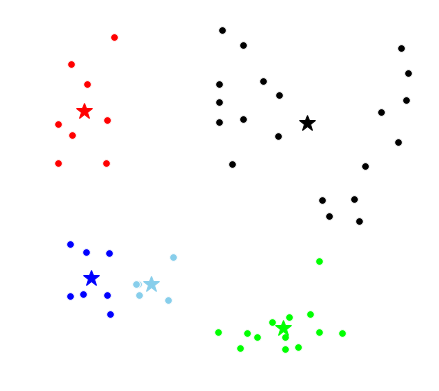

In [22]:
# print out dataset again, only with each cluster colored individually, 
# and plot centroids
plotting_util.cluster_plot_2d(X,centroids,assignments)

Hmm....Doesn't seem like its guaranteed to give the intuitively best answer any more than our regular solution.  Perhaps taking the sum of our errors isn't the greatest method of measuing our models overall fit?

Open to suggestions on how to improve this!